In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_13/47588328.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(batch_states, dtype=torch.float32, device=self.device)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na op

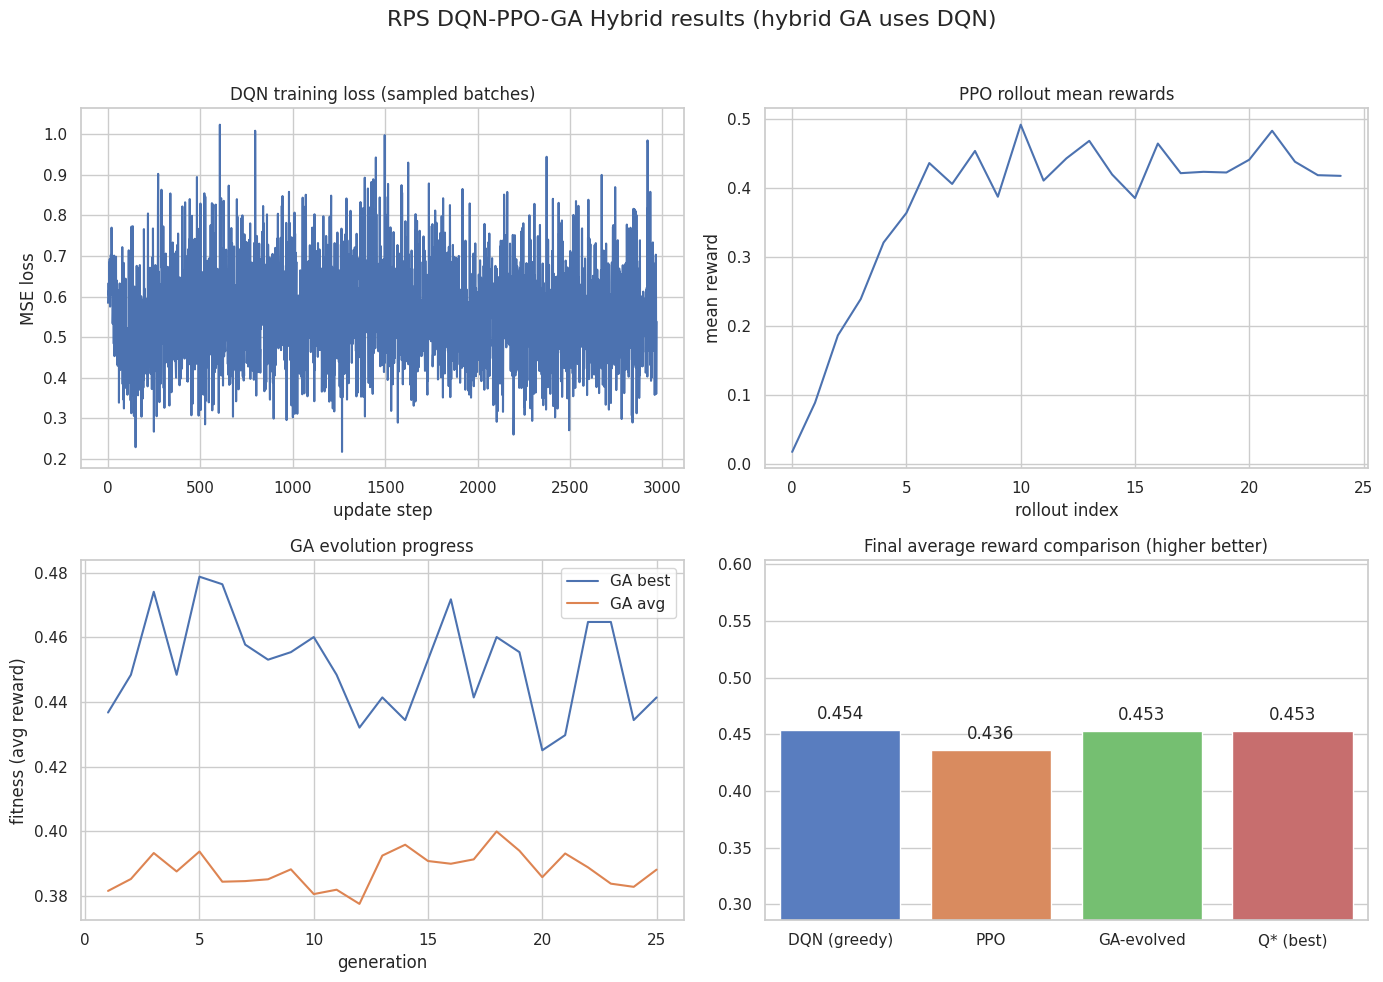

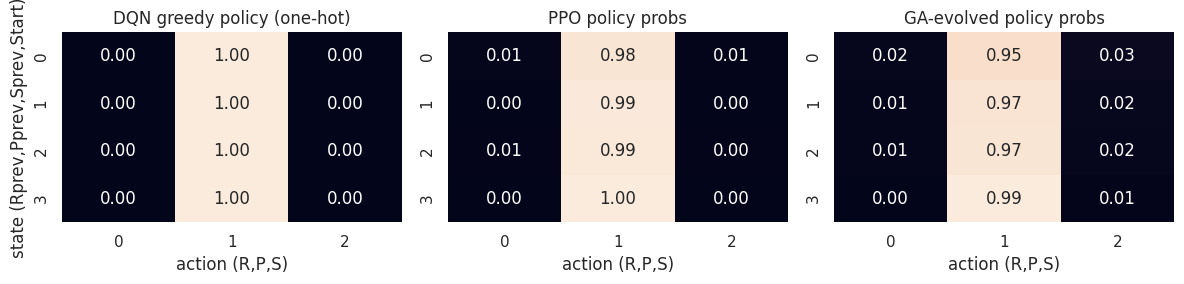


Numeric summary:


In [2]:


import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from typing import Tuple, List

sns.set(style="whitegrid")

# ---------------------------
# Environment
# ---------------------------
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

ACTIONS = ['R', 'P', 'S']
NUM_ACTIONS = 3
NUM_STATES = 4  # 0:R_prev,1:P_prev,2:S_prev,3:Start

def rps_reward(a:int, b:int) -> int:
    if a == b:
        return 0
    wins = {(0,2),(1,0),(2,1)}
    return 1 if (a,b) in wins else -1

class Opponent:
    def __init__(self, probs=(0.6,0.25,0.15)):
        self.probs = np.array(probs, dtype=float)
        self.probs /= self.probs.sum()
    def act(self):
        return int(np.random.choice(NUM_ACTIONS, p=self.probs))

class RPSEnv:
    """Simple one-step RPS environment with state = previous opponent action."""
    def __init__(self, opponent: Opponent):
        self.opponent = opponent
        self.prev = 3
    def reset(self):
        self.prev = 3
        return self.prev
    def step(self, action:int) -> Tuple[int,int]:
        opp = self.opponent.act()
        r = rps_reward(action, opp)
        self.prev = opp
        return self.prev, r

def state_to_onehot(s:int) -> np.ndarray:
    v = np.zeros(NUM_STATES, dtype=np.float32)
    v[s] = 1.0
    return v

# ---------------------------
# DQN (Deep Q Network)
# ---------------------------
class DQNNet(nn.Module):
    def __init__(self, state_dim=NUM_STATES, action_dim=NUM_ACTIONS, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, lr=1e-3, gamma=0.99, device='cpu'):
        self.device = device
        self.net = DQNNet().to(self.device)
        self.target = deepcopy(self.net).to(self.device)
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma
        self.loss_fn = nn.MSELoss()
        self.update_count = 0
    def act(self, state:np.ndarray, eps:float=0.1):
        if random.random() < eps:
            return random.randrange(NUM_ACTIONS)
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q = self.net(s).detach().cpu().numpy()[0]
        return int(np.argmax(q))
    def train_step(self, batch_states, batch_actions, batch_rewards, batch_next_states):
        states = torch.tensor(batch_states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(batch_actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(batch_rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(batch_next_states, dtype=torch.float32, device=self.device)
        q_values = self.net(states).gather(1, actions)
        with torch.no_grad():
            q_next = self.target(next_states).max(dim=1, keepdim=True)[0]
            q_target = rewards + self.gamma * q_next
        loss = self.loss_fn(q_values, q_target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        self.update_count += 1
        # soft update target
        if self.update_count % 50 == 0:
            for p, tp in zip(self.net.parameters(), self.target.parameters()):
                tp.data.copy_(0.995*tp.data + 0.005*p.data)
        return float(loss.detach().cpu().numpy())

# ---------------------------
# PPO Actor-Critic
# ---------------------------
class ActorCritic(nn.Module):
    def __init__(self, state_dim=NUM_STATES, action_dim=NUM_ACTIONS, hidden=64):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.Tanh()
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.Tanh(),
            nn.Linear(hidden//2, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.Tanh(),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        x = self.shared(x)
        logits = self.actor(x)
        value = self.critic(x).squeeze(-1)
        return logits, value

class PPOTrainer:
    def __init__(self, lr_actor=3e-4, lr_critic=1e-3, clip=0.2, device='cpu'):
        self.device = device
        self.model = ActorCritic().to(device)
        self.opt = optim.Adam([
            {'params': self.model.shared.parameters()},
            {'params': self.model.actor.parameters(), 'lr': lr_actor},
            {'params': self.model.critic.parameters(), 'lr': lr_critic}
        ])
        self.clip = clip
    def get_action_and_value(self, state):
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits, value = self.model(s)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return int(a.item()), float(dist.log_prob(a).item()), float(value.item()), probs.detach().cpu().numpy()[0]
    def update(self, states, actions, old_logps, returns, advs, epochs=4, batch_size=64):
        states_t = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions_t = torch.tensor(actions, dtype=torch.long, device=self.device)
        old_logps_t = torch.tensor(old_logps, dtype=torch.float32, device=self.device)
        returns_t = torch.tensor(returns, dtype=torch.float32, device=self.device)
        advs_t = torch.tensor(advs, dtype=torch.float32, device=self.device)
        advs_t = (advs_t - advs_t.mean()) / (advs_t.std() + 1e-8)

        n = states_t.shape[0]
        inds = np.arange(n)
        loss_policy = 0.0
        loss_value = 0.0
        for _ in range(epochs):
            np.random.shuffle(inds)
            for start in range(0, n, batch_size):
                mb = inds[start:start+batch_size]
                logits, values = self.model(states_t[mb])
                dist = torch.distributions.Categorical(logits=logits)
                logps = dist.log_prob(actions_t[mb])
                ratio = (logps - old_logps_t[mb]).exp()
                surr1 = ratio * advs_t[mb]
                surr2 = torch.clamp(ratio, 1.0 - self.clip, 1.0 + self.clip) * advs_t[mb]
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = ((returns_t[mb] - values).pow(2)).mean()
                entropy = dist.entropy().mean()
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                loss_policy += float(policy_loss.detach().cpu().numpy())
                loss_value += float(value_loss.detach().cpu().numpy())
        return loss_policy, loss_value

# ---------------------------
# Genetic Algorithm (mutate PPO actor weights)
# ---------------------------
def extract_actor_weights(model: ActorCritic):
    # returns a flat numpy vector of actor parameters
    params = []
    for p in model.actor.parameters():
        params.append(p.detach().cpu().numpy().ravel())
    return np.concatenate(params)

def inject_actor_weights(model: ActorCritic, flat_weights: np.ndarray):
    # writes flat_weights into model.actor params
    ptr = 0
    for p in model.actor.parameters():
        num = p.numel()
        chunk = flat_weights[ptr:ptr+num]
        p.data.copy_(torch.tensor(chunk.reshape(p.shape), dtype=p.dtype))
        ptr += num

def ga_evolve_policy(base_model: ActorCritic, pop_size=50, generations=30, mut_scale=0.1, elite_frac=0.1,
                     eval_episodes=200, use_dqn_value=False, dqn_agent: DQNAgent=None):
    """
    Evolve actor weights starting from base_model. If use_dqn_value True, add a DQN-derived
    Q-value baseline to the GA fitness to form a hybrid selection.
    """
    base_flat = extract_actor_weights(base_model)
    pop = [base_flat + np.random.randn(base_flat.size)*mut_scale for _ in range(pop_size)]
    elite_n = max(1, int(pop_size*elite_frac))
    best_hist, avg_hist = [], []
    for gen in range(generations):
        fitnesses = []
        for ind in pop:
            # evaluate policy
            # inject weights to a temporary copy of model
            model_copy = deepcopy(base_model)
            inject_actor_weights(model_copy, ind)
            # evaluate average reward
            env = RPSEnv(Opponent())
            tot = 0.0
            for _ in range(eval_episodes):
                s = env.reset()
                s_oh = state_to_onehot(s)
                with torch.no_grad():
                    logits, _ = model_copy(torch.tensor(s_oh).unsqueeze(0).float())
                    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                a = int(np.random.choice(NUM_ACTIONS, p=probs))
                s2, r = env.step(a)
                tot += r
            avg_reward = tot / eval_episodes
            # optional hybrid: include DQN estimate for current state (start state) to bias fitness
            if use_dqn_value and (dqn_agent is not None):
                q_start = dqn_agent.net(torch.tensor(state_to_onehot(3)).float().unsqueeze(0)).detach().cpu().numpy().max()
                # combine: e.g., weighted sum (0.7*policy_reward + 0.3*Q_estimate) scaled
                hybrid_fitness = 0.7 * avg_reward + 0.3 * float(q_start)
                fitnesses.append(hybrid_fitness)
            else:
                fitnesses.append(avg_reward)
        fitnesses = np.array(fitnesses)
        idx = np.argsort(-fitnesses)
        best_hist.append(float(fitnesses[idx[0]]))
        avg_hist.append(float(fitnesses.mean()))
        # elitism
        new_pop = [pop[i] for i in idx[:elite_n]]
        # fill rest by crossover + mutation
        while len(new_pop) < pop_size:
            p1 = pop[random.choice(idx[:pop_size//2])]
            p2 = pop[random.choice(idx[:pop_size//2])]
            mask = np.random.rand(base_flat.size) < 0.5
            child = np.where(mask, p1, p2).copy()
            # mutate
            child += np.random.randn(base_flat.size) * (mut_scale * (np.random.rand(base_flat.size) < 0.05))
            new_pop.append(child)
        pop = new_pop
    # return best individual
    best_idx = int(np.argmax(fitnesses))
    best_flat = pop[best_idx]
    return best_flat, best_hist, avg_hist

# ---------------------------
# Training & experiment driver
# ---------------------------
def run_experiment(
    dqn_steps=2000,
    ppo_timesteps=20000,
    ppo_rollout_steps=1024,
    ga_generations=30,
    ga_pop=40,
    hybrid_ga=False
):
    device = 'cpu'
    # 1) Train DQN with random replay (very simple fit since environment is one-step)
    dqn = DQNAgent(lr=1e-3, gamma=0.99, device=device)
    env = RPSEnv(Opponent())
    replay = []
    losses = []
    eps = 0.2
    state = env.reset()
    for t in range(dqn_steps):
        s_oh = state_to_onehot(state)
        a = dqn.act(s_oh, eps=eps)
        s2, r = env.step(a)
        replay.append((s_oh, a, r, state_to_onehot(s2)))
        if len(replay) > 5000:
            replay.pop(0)
        # sample mini-batch
        if len(replay) >= 32:
            batch = random.sample(replay, 32)
            bs, ba, br, bn = zip(*batch)
            loss = dqn.train_step(bs, ba, br, bn)
            losses.append(loss)
        state = s2
        if (t+1) % 500 == 0:
            eps = max(0.05, eps*0.9)

    # 2) Train PPO (actor-critic)
    ppo = PPOTrainer(device=device)
    ppo_rewards = []
    # We'll collect many rollouts of one-step interactions (easy to treat)
    total_steps = 0
    while total_steps < ppo_timesteps:
        states, actions, old_logps, rewards, values = [], [], [], [], []
        # collect rollout
        for _ in range(ppo_rollout_steps):
            s = env.reset()
            s_oh = state_to_onehot(s)
            a, logp, val, probs = ppo.get_action_and_value(s_oh)
            s2, r = env.step(a)
            states.append(s_oh)
            actions.append(a)
            old_logps.append(logp)
            rewards.append(r)
            values.append(val)
            total_steps += 1
        # compute returns and advantages (simple: no episode continuation)
        returns, advs = [], []
        for i in range(len(rewards)):
            # one-step: return = reward + gamma*0 (no next-step bootstrapping)
            returns.append(rewards[i])
            advs.append(rewards[i] - values[i])
        # update PPO
        ppo.update(states, actions, old_logps, returns, advs, epochs=6, batch_size=128)
        ppo_rewards.append(np.mean(rewards))

    # 3) GA evolving PPO actor: baseline PPO actor weights
    base_model = ppo.model
    # if hybrid_ga True use DQN in fitness
    best_flat, ga_best_hist, ga_avg_hist = ga_evolve_policy(base_model, pop_size=ga_pop,
                                                           generations=ga_generations,
                                                           mut_scale=0.08, elite_frac=0.12,
                                                           eval_episodes=300,
                                                           use_dqn_value=hybrid_ga,
                                                           dqn_agent=dqn if hybrid_ga else None)
    # inject best weights into a copy of PPO model
    evolved_model = deepcopy(base_model)
    inject_actor_weights(evolved_model, best_flat)

    # Evaluate final policies
    def eval_model_policy(model, episodes=2000):
        env_local = RPSEnv(Opponent())
        total = 0.0
        for _ in range(episodes):
            s = env_local.reset()
            s_oh = torch.tensor(state_to_onehot(s)).float().unsqueeze(0)
            with torch.no_grad():
                logits, _ = model(s_oh)
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
            a = int(np.random.choice(NUM_ACTIONS, p=probs))
            s2, r = env_local.step(a)
            total += r
        return total / episodes

    # Q greedy policy
    q_policy_probs = np.zeros((NUM_STATES, NUM_ACTIONS))
    # construct greedy from DQN net
    for s in range(NUM_STATES):
        qvals = dqn.net(torch.tensor(state_to_onehot(s)).float().unsqueeze(0)).detach().cpu().numpy()[0]
        best = int(np.argmax(qvals))
        q_policy_probs[s, best] = 1.0

    q_score = evaluate_policy_probs = None
    # evaluate Q policy by sampling
    def eval_policy_probs_local(policy_probs, episodes=2000):
        env_local = RPSEnv(Opponent())
        tot = 0.0
        for _ in range(episodes):
            s = env_local.reset()
            a = int(np.random.choice(NUM_ACTIONS, p=policy_probs[s]))
            s2, r = env_local.step(a)
            tot += r
        return tot / episodes

    q_score = eval_policy_probs_local(q_policy_probs)
    ppo_score = eval_model_policy(ppo.model)
    evolved_score = eval_model_policy(evolved_model)
    q_star_score = max(ppo_score, evolved_score)

    results = {
        'dqn_losses': losses,
        'ppo_rewards': ppo_rewards,
        'ga_best_hist': ga_best_hist,
        'ga_avg_hist': ga_avg_hist,
        'q_score': q_score,
        'ppo_score': ppo_score,
        'evolved_score': evolved_score,
        'q_star': q_star_score,
        'q_policy_probs': q_policy_probs,
        'ppo_policy_probs': None,  # we can extract below
        'evolved_policy_probs': None
    }

    # extract PPO probs per state
    ppo_probs = []
    for s in range(NUM_STATES):
        s_oh = torch.tensor(state_to_onehot(s)).float().unsqueeze(0)
        with torch.no_grad():
            logits, _ = ppo.model(s_oh)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        ppo_probs.append(probs)
    results['ppo_policy_probs'] = np.vstack(ppo_probs)

    # evolved model probs
    evo_probs = []
    for s in range(NUM_STATES):
        s_oh = torch.tensor(state_to_onehot(s)).float().unsqueeze(0)
        with torch.no_grad():
            logits, _ = evolved_model(s_oh)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        evo_probs.append(probs)
    results['evolved_policy_probs'] = np.vstack(evo_probs)

    return results

# ---------------------------
# Plotting utilities
# ---------------------------
def plot_results(results, title_suffix="", save_prefix=None):
    plt.figure(figsize=(14,10))

    # subplot 1: DQN losses
    plt.subplot(2,2,1)
    if len(results['dqn_losses'])>0:
        sns.lineplot(data=results['dqn_losses'])
        plt.title("DQN training loss (sampled batches)")
        plt.xlabel("update step")
        plt.ylabel("MSE loss")
    else:
        plt.text(0.1,0.5,"No DQN updates collected", fontsize=12)

    # subplot 2: PPO training progression
    plt.subplot(2,2,2)
    sns.lineplot(data=results['ppo_rewards'])
    plt.title("PPO rollout mean rewards")
    plt.xlabel("rollout index")
    plt.ylabel("mean reward")

    # subplot 3: GA progress
    plt.subplot(2,2,3)
    gens = np.arange(1, len(results['ga_best_hist'])+1)
    sns.lineplot(x=gens, y=results['ga_best_hist'], label='GA best')
    sns.lineplot(x=gens, y=results['ga_avg_hist'], label='GA avg')
    plt.title("GA evolution progress")
    plt.xlabel("generation")
    plt.ylabel("fitness (avg reward)")
    plt.legend()

    # subplot 4: final policies comparison bar chart
    plt.subplot(2,2,4)
    labels = ['DQN (greedy)', 'PPO', 'GA-evolved', 'Q* (best)']
    scores = [results['q_score'], results['ppo_score'], results['evolved_score'], results['q_star']]
    sns.barplot(x=labels, y=scores, palette="muted")
    plt.title("Final average reward comparison (higher better)")
    plt.ylim(min(scores)-0.15, max(scores)+0.15)
    for i, v in enumerate(scores):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center')

    plt.suptitle(f"RPS DQN-PPO-GA Hybrid results {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    if save_prefix:
        plt.savefig(f"{save_prefix}_summary.png", dpi=200)
    plt.show()

    # Additional: heatmap showing action probabilities for models (states x actions)
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    sns.heatmap(results['q_policy_probs'], ax=axes[0], annot=True, fmt=".2f", cbar=False)
    axes[0].set_title("DQN greedy policy (one-hot)")
    axes[0].set_xlabel("action (R,P,S)")
    axes[0].set_ylabel("state (Rprev,Pprev,Sprev,Start)")

    sns.heatmap(results['ppo_policy_probs'], ax=axes[1], annot=True, fmt=".2f", cbar=False)
    axes[1].set_title("PPO policy probs")
    axes[1].set_xlabel("action (R,P,S)")

    sns.heatmap(results['evolved_policy_probs'], ax=axes[2], annot=True, fmt=".2f", cbar=False)
    axes[2].set_title("GA-evolved policy probs")
    axes[2].set_xlabel("action (R,P,S)")

    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_policies.png", dpi=200)
    plt.show()

# ---------------------------
# Run and plot
# ---------------------------
if __name__ == "__main__":
    # quick run (tweak params as needed)
    res = run_experiment(
        dqn_steps=3000,
        ppo_timesteps=25000,
        ppo_rollout_steps=1024,
        ga_generations=25,
        ga_pop=50,
        hybrid_ga=True   # use DQN Q estimate in GA fitness (hybrid)
    )
    plot_results(res, title_suffix="(hybrid GA uses DQN)", save_prefix="rps_hybrid_results")

    # print numeric summaries and policies
    print("\nNumeric summary:")